# Imports

In [140]:
import gzip
import ast
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from langdetect import detect
from collections import defaultdict, Counter
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
)
import scipy.sparse as sp
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics.pairwise import cosine_similarity

# Set style for charts
sns.set_style("whitegrid")
plt.rcParams["figure.figsize"] = (12, 6)

# Elementary Data Analysis

## Review Data

In [124]:
review_data = []
with gzip.open("dataset/australian_user_reviews.json.gz", "rt", encoding="utf-8") as f:
    for line in f:
        obj = ast.literal_eval(line)  # parses python dict syntax
        review_data.append(obj)

print(len(review_data))
print(review_data[0])

25799
{'user_id': '76561197970982479', 'user_url': 'http://steamcommunity.com/profiles/76561197970982479', 'reviews': [{'funny': '', 'posted': 'Posted November 5, 2011.', 'last_edited': '', 'item_id': '1250', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Simple yet with great replayability. In my opinion does "zombie" hordes and team work better than left 4 dead plus has a global leveling system. Alot of down to earth "zombie" splattering fun for the whole family. Amazed this sort of FPS is so rare.'}, {'funny': '', 'posted': 'Posted July 15, 2011.', 'last_edited': '', 'item_id': '22200', 'helpful': 'No ratings yet', 'recommend': True, 'review': "It's unique and worth a playthrough."}, {'funny': '', 'posted': 'Posted April 21, 2011.', 'last_edited': '', 'item_id': '43110', 'helpful': 'No ratings yet', 'recommend': True, 'review': 'Great atmosphere. The gunplay can be a bit chunky at times but at the end of the day this game is definitely worth it and I hope they do a seque

In [125]:
# Flatten the dataset (one row per review)
rows = []
for user in review_data:
    for r in user["reviews"]:
        rows.append(
            {
                "user_id": user["user_id"],
                "game_id": r["item_id"],
                "posted": r["posted"],
                "recommend": r["recommend"],
                "text": r["review"],
            }
        )

review_df = pd.DataFrame(rows)
review_df.head()

,user_id,game_id,posted,recommend,text
0,76561197970982479,1250,"Posted November 5, 2011.",True,Simple yet with great replayability. In my opi...
1,76561197970982479,22200,"Posted July 15, 2011.",True,It's unique and worth a playthrough.
2,76561197970982479,43110,"Posted April 21, 2011.",True,Great atmosphere. The gunplay can be a bit chu...
3,js41637,251610,"Posted June 24, 2014.",True,I know what you think when you see this title ...
4,js41637,227300,"Posted September 8, 2013.",True,For a simple (it's actually not all that simpl...


In [120]:
print("Number of users:", review_df["user_id"].nunique())
print("Number of reviews:", len(review_df))
print("Number of games:", review_df["game_id"].nunique())
print("Recommend rate:", review_df["recommend"].mean())

Number of users: 25458
Number of reviews: 59305
Number of games: 3682
Recommend rate: 0.8847989208329821


In [4]:
def detect_lang_safe(text):
    try:
        return detect(text)
    except:
        return "unknown"


review_df["lang"] = review_df["text"].apply(detect_lang_safe)

non_english_count = (review_df["lang"] != "en").sum()

review_df["lang"].value_counts()

lang
en         45775
pt          2189
es          1283
de          1157
so          1025
af           751
th           713
unknown      591
tl           584
cy           440
da           406
no           369
nl           304
ca           263
it           247
pl           243
id           243
ro           239
ko           239
fr           236
ru           214
zh-cn        210
et           181
sw           179
tr           166
sl           140
hr           140
vi           125
sq           113
fi            97
hu            90
sk            77
sv            73
cs            43
lt            41
ja            36
lv            33
bg            21
uk            13
zh-tw          7
mk             6
ar             2
ta             1
Name: count, dtype: int64

## User Data

In [126]:
import gzip
import ast
from tqdm import tqdm

user_data = []

# Optionally, get the total number of lines for a proper progress bar
with gzip.open("dataset/australian_users_items.json.gz", "rt", encoding="utf-8") as f:
    for line in tqdm(f, desc="Loading data"):
        obj = ast.literal_eval(line)  # parses python dict syntax
        user_data.append(obj)

print(len(user_data))
print(user_data[0])

Loading data: 88310it [00:59, 1475.86it/s]

88310
{'user_id': '76561197970982479', 'items_count': 277, 'steam_id': '76561197970982479', 'user_url': 'http://steamcommunity.com/profiles/76561197970982479', 'items': [{'item_id': '10', 'item_name': 'Counter-Strike', 'playtime_forever': 6, 'playtime_2weeks': 0}, {'item_id': '20', 'item_name': 'Team Fortress Classic', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '30', 'item_name': 'Day of Defeat', 'playtime_forever': 7, 'playtime_2weeks': 0}, {'item_id': '40', 'item_name': 'Deathmatch Classic', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '50', 'item_name': 'Half-Life: Opposing Force', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '60', 'item_name': 'Ricochet', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '70', 'item_name': 'Half-Life', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '130', 'item_name': 'Half-Life: Blue Shift', 'playtime_forever': 0, 'playtime_2weeks': 0}, {'item_id': '300', 'item_name': 'Day of Defeat: Sour

In [127]:
# Flatten the dataset (one row per user-game pair)
rows = []
for user in user_data:
    for g in user["items"]:
        rows.append(
            {
                "user_id": user["user_id"],
                "game_id": g["item_id"],
                "game_name": g["item_name"],
                "total_playtime": g["playtime_forever"],
                "recent_playtime": g["playtime_2weeks"],
            }
        )

user_df = pd.DataFrame(rows)
user_df.head()

,user_id,game_id,game_name,total_playtime,recent_playtime
0,76561197970982479,10,Counter-Strike,6,0
1,76561197970982479,20,Team Fortress Classic,0,0
2,76561197970982479,30,Day of Defeat,7,0
3,76561197970982479,40,Deathmatch Classic,0,0
4,76561197970982479,50,Half-Life: Opposing Force,0,0


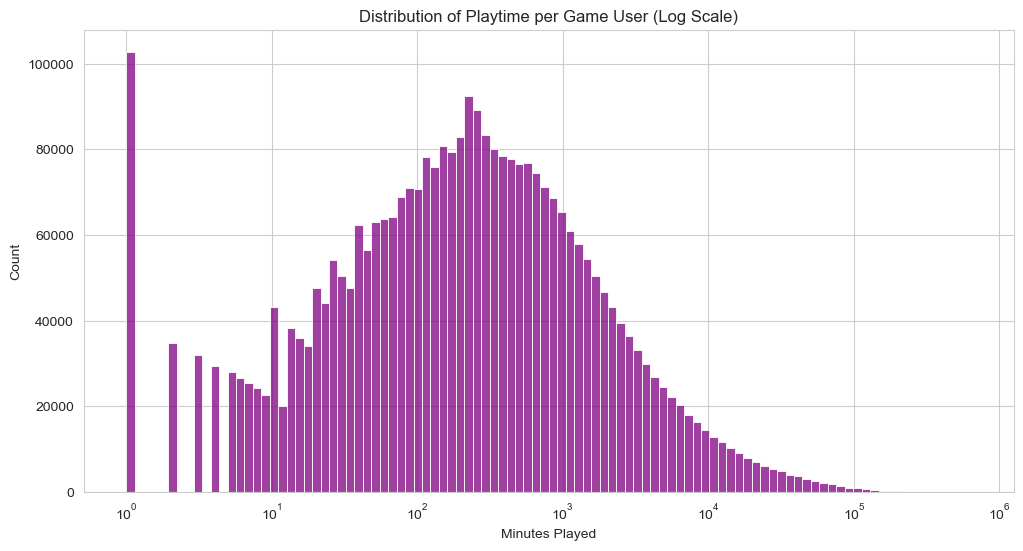

In [76]:
# Cell: Playtime Distribution

# Filter out 0 playtime (backlog games) to see actual engagement
played_games = user_df[user_df["total_playtime"] > 0]

plt.figure(figsize=(12, 6))
sns.histplot(
    played_games["total_playtime"], bins=100, log_scale=True, color="purple"
)
plt.title("Distribution of Playtime per Game User (Log Scale)")
plt.xlabel("Minutes Played")
plt.show()

In [87]:
print(
    f"Proportion of games with 0 playime: {1 - (len(user_df[user_df["total_playtime"] > 0]) / len(user_df))}"
)

Proportion of games with 0 playime: 0.36248539502279065


Matrix Sparsity: 99.3380%


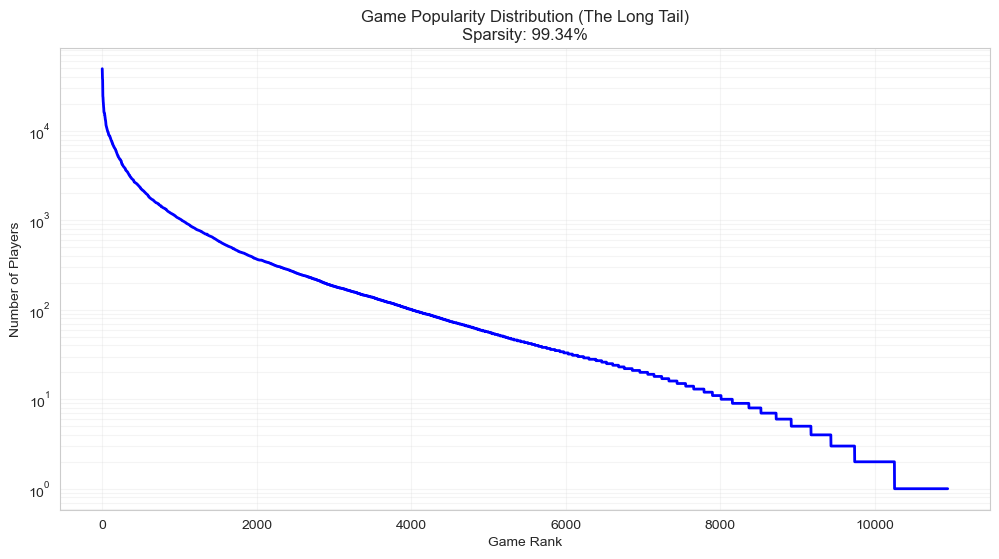

In [56]:
# Calculate popularity (number of users per game)
game_popularity_counts = list(user_df["game_name"].value_counts())

# Calculate Sparsity
total_possible_interactions = len(user_df["user_id"].unique()) * len(user_df["game_id"].unique())
total_actual_interactions = sum(game_popularity_counts)
sparsity = 1 - (total_actual_interactions / total_possible_interactions)
print(f"Matrix Sparsity: {sparsity:.4%}")

# Plot Long Tail
plt.figure(figsize=(12, 6))
plt.plot(game_popularity_counts, color="blue", linewidth=2)
plt.title(f"Game Popularity Distribution (The Long Tail)\nSparsity: {sparsity:.2%}")
plt.xlabel("Game Rank")
plt.ylabel("Number of Players")
plt.yscale("log")  # Log scale emphasizes the tail
plt.grid(True, which="both", ls="-", alpha=0.2)
plt.show()

## Game Data

In [128]:
import gzip
import ast
from tqdm import tqdm

game_data = []

# Optionally, get the total number of lines for a proper progress bar
with gzip.open("dataset/steam_games.json.gz", "rt", encoding="utf-8") as f:
    for line in tqdm(f, desc="Loading data"):
        obj = ast.literal_eval(line)  # parses python dict syntax
        game_data.append(obj)

print(len(game_data))
print(game_data[0])

Loading data: 32135it [00:01, 23461.33it/s]

32135
{'publisher': 'Kotoshiro', 'genres': ['Action', 'Casual', 'Indie', 'Simulation', 'Strategy'], 'app_name': 'Lost Summoner Kitty', 'title': 'Lost Summoner Kitty', 'url': 'http://store.steampowered.com/app/761140/Lost_Summoner_Kitty/', 'release_date': '2018-01-04', 'tags': ['Strategy', 'Action', 'Indie', 'Casual', 'Simulation'], 'discount_price': 4.49, 'reviews_url': 'http://steamcommunity.com/app/761140/reviews/?browsefilter=mostrecent&p=1', 'specs': ['Single-player'], 'price': 4.99, 'early_access': False, 'id': '761140', 'developer': 'Kotoshiro'}


In [129]:
# Flatten the dataset (one row per user-game pair)
rows = []
for game in game_data:
    rows.append(
        {
            "title": game["title"] if "title" in game.keys() else "",
            "game_id": game["id"] if "id" in game.keys() else None,
            "publisher": game["publisher"] if "publisher" in game.keys() else None,
            "developer": game["developer"] if "developer" in game.keys() else None,
            "release_date": (
                game["release_date"] if "release_date" in game.keys() else None
            ),
            "price": game["price"] if "price" in game.keys() else None,
            "genres": game["genres"] if "genres" in game.keys() else [],
            "tags": game["tags"] if "tags" in game.keys() else [],
            "specs": game["specs"] if "specs" in game.keys() else [],
        }
    )

game_df = pd.DataFrame(rows)

def clean_price(x):
    if isinstance(x, str):
        if "free" in x.lower():
            return 0.0
        try:
            return float(x)
        except:
            return 0.0
    return x

game_df["clean_price"] = game_df["price"].apply(clean_price)

game_df.head()

,title,game_id,publisher,developer,release_date,price,genres,tags,specs,clean_price
0,Lost Summoner Kitty,761140,Kotoshiro,Kotoshiro,2018-01-04,4.99,"[Action, Casual, Indie, Simulation, Strategy]","[Strategy, Action, Indie, Casual, Simulation]",[Single-player],4.99
1,Ironbound,643980,"Making Fun, Inc.",Secret Level SRL,2018-01-04,Free To Play,"[Free to Play, Indie, RPG, Strategy]","[Free to Play, Strategy, Indie, RPG, Card Game...","[Single-player, Multi-player, Online Multi-Pla...",0.00
2,Real Pool 3D - Poolians,670290,Poolians.com,Poolians.com,2017-07-24,Free to Play,"[Casual, Free to Play, Indie, Simulation, Sports]","[Free to Play, Simulation, Sports, Casual, Ind...","[Single-player, Multi-player, Online Multi-Pla...",0.00
3,弹炸人2222,767400,彼岸领域,彼岸领域,2017-12-07,0.99,"[Action, Adventure, Casual]","[Action, Adventure, Casual]",[Single-player],0.99
4,,773570,None,None,None,2.99,[],"[Action, Indie, Casual, Sports]","[Single-player, Full controller support, HTC V...",2.99


/var/folders/d_/qt9yhc2549s7ghqsdf91y2l40000gn/T/ipykernel_4815/4281289115.py:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_genres.values, y=top_genres.index, palette="magma")


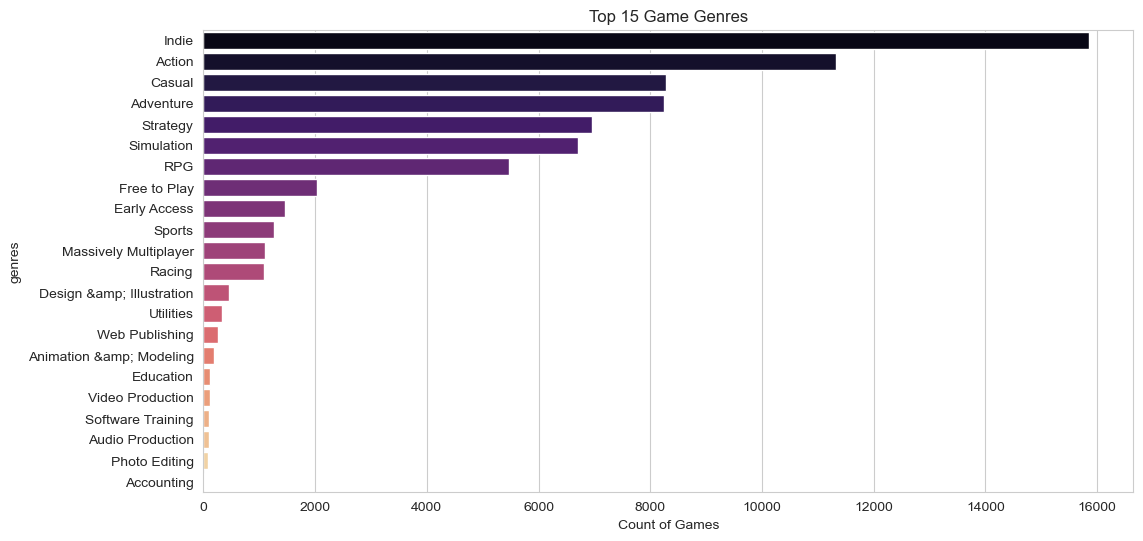

In [61]:
# 2. Explode Genres for visualization
genres_exploded = game_df.explode("genres")

# Plot Top Genres
plt.figure(figsize=(12, 6))
top_genres = genres_exploded["genres"].value_counts()
sns.barplot(x=top_genres.values, y=top_genres.index, palette="magma")
plt.title("Top 15 Game Genres")
plt.xlabel("Count of Games")
plt.show()

/var/folders/d_/qt9yhc2549s7ghqsdf91y2l40000gn/T/ipykernel_4815/3543728677.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(tags), palette="viridis")


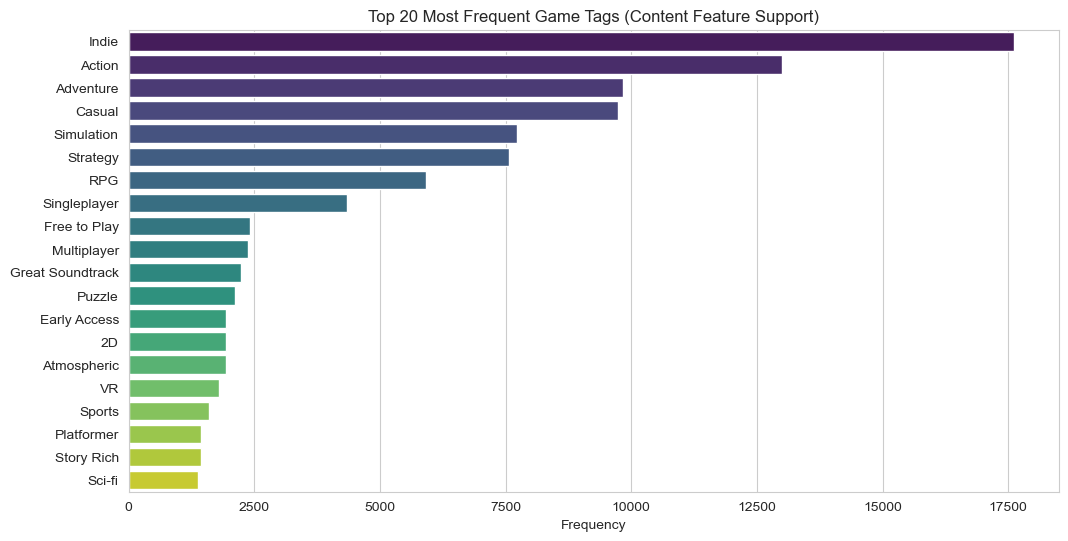

In [64]:
# Cell: Tag Frequency Analysis

# Aggregate all tags
all_tags = []
for tags_list in game_df["tags"]:
    if isinstance(tags_list, list):
        all_tags.extend(tags_list)

# Get top 20 tags
tag_counts = Counter(all_tags).most_common(20)
tags, counts = zip(*tag_counts)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(tags), palette="viridis")
plt.title("Top 20 Most Frequent Game Tags (Content Feature Support)")
plt.xlabel("Frequency")
plt.show()

/var/folders/d_/qt9yhc2549s7ghqsdf91y2l40000gn/T/ipykernel_4815/118015745.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=list(counts), y=list(specs), palette="viridis")


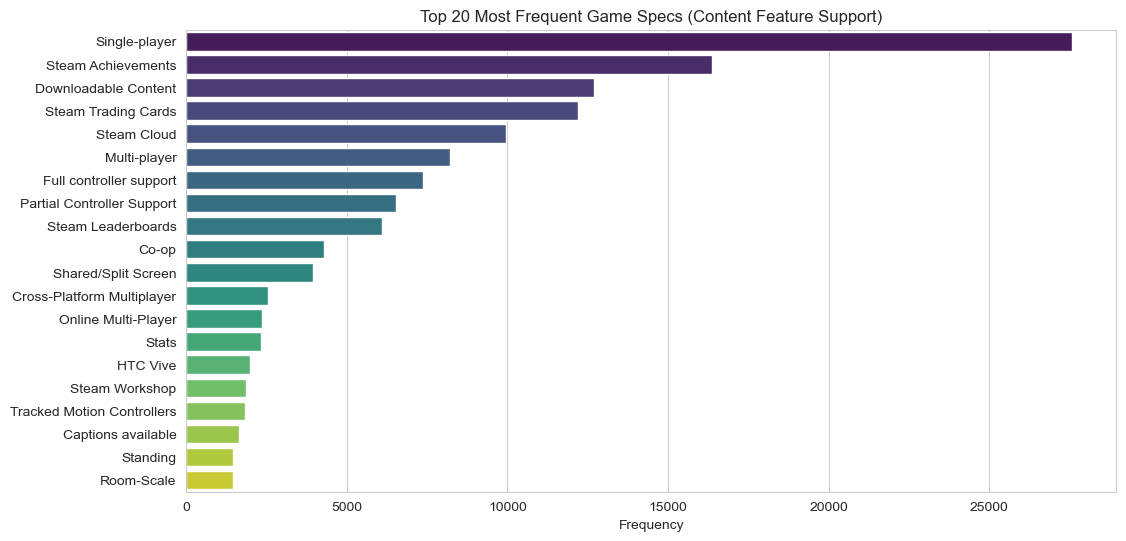

In [68]:
# Cell: Specs Frequency Analysis

# Aggregate all specs
all_specs = []
for specs_list in game_df["specs"]:
    if isinstance(specs_list, list):
        all_specs.extend(specs_list)

# Get top 20 specs
specs_counts = Counter(all_specs).most_common(20)
specs, counts = zip(*specs_counts)

plt.figure(figsize=(12, 6))
sns.barplot(x=list(counts), y=list(specs), palette="viridis")
plt.title("Top 20 Most Frequent Game Specs (Content Feature Support)")
plt.xlabel("Frequency")
plt.show()

In [110]:
# Correlation between Price and Popularity
# (Does a higher price imply a better/more popular game?)
game_popularities = user_df["game_id"].value_counts()
game_stats = []
for _, game in game_df.iterrows():
    try:
        game_pop = game_popularities[str(game["game_id"])]
    except:
        game_pop = 0
    game_stats.append({"price": game["clean_price"], "popularity": game_pop})

stats_df = pd.DataFrame(game_stats)
corr = stats_df.corr().iloc[0, 1]

print(f"Correlation between Price and Popularity: {corr:.4f}")

Correlation between Price and Popularity: 0.0334


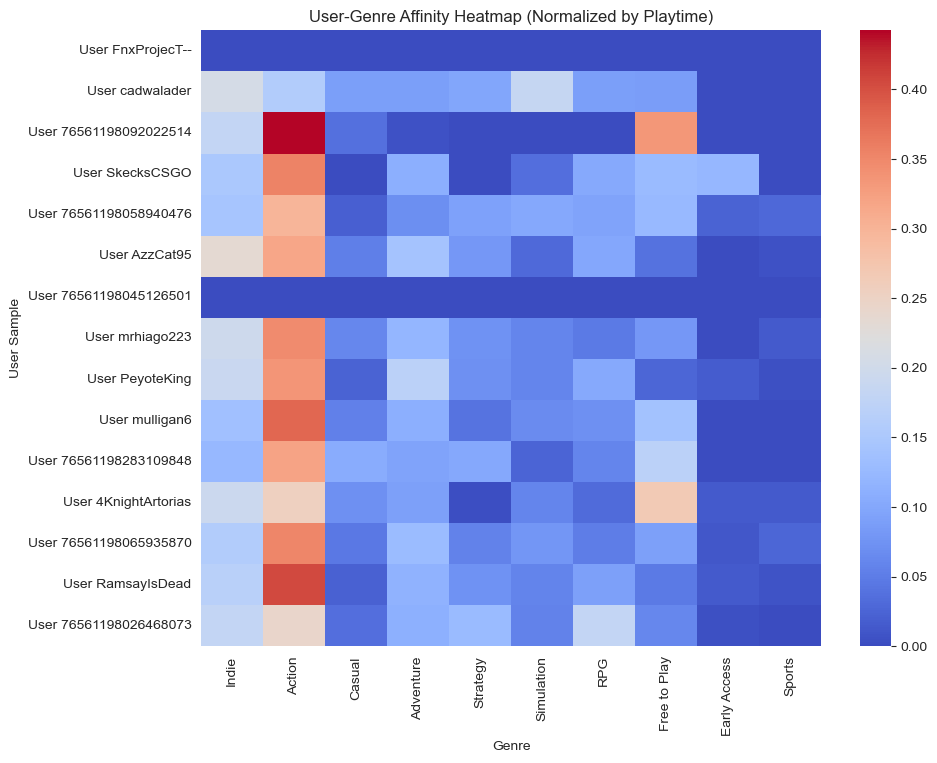

In [137]:
# Cell: User-Genre Affinity Heatmap (Sample)
# We will look at a random sample of 10 users and 10 popular genres to visualize distinct tastes

# 1. Get top 10 genres
all_genres = []
for g_list in game_df["genres"]:
    if isinstance(g_list, list):
        all_genres.extend(g_list)
top_genres_list = [g for g, _ in Counter(all_genres).most_common(10)]

# 2. Build a mini matrix for 15 random users
sample_users_ids = random.sample(list(user_df["user_id"].unique()), 15)
heatmap_data = np.zeros((15, 10))

for i, user_id in enumerate(sample_users_ids):
    interactions = user_df[user_df["user_id"] == user_id]

    for _, game in interactions.iterrows():
        # Get genres for this game
        g_list = game_df[game_df["game_id"] == game["game_id"]]["genres"]
        for genre_list in g_list:
            for g in genre_list:
                if g in top_genres_list:
                    g_idx = top_genres_list.index(g)
                    # Add log playtime to heatmap
                    heatmap_data[i, g_idx] += np.log1p(game["total_playtime"])

# Normalize per user for visualization
heatmap_data = heatmap_data / (heatmap_data.sum(axis=1, keepdims=True) + 1e-9)

plt.figure(figsize=(10, 8))
sns.heatmap(
    heatmap_data,
    xticklabels=top_genres_list,
    yticklabels=[f"User {u}" for u in sample_users_ids],
    cmap="coolwarm",
)
plt.title("User-Genre Affinity Heatmap (Normalized by Playtime)")
plt.xlabel("Genre")
plt.ylabel("User Sample")
plt.show()

# Preprocessing

In [20]:
# load user-item interactions
data = []
with gzip.open("dataset/australian_users_items.json.gz", "rt", encoding="utf-8") as f:
    for line in tqdm(f, desc="Loading user-item data"):
        obj = ast.literal_eval(line)
        data.append(obj)

print(f"Loaded {len(data)} users")

# load item metadata
item_metadata = {}
with gzip.open("dataset/steam_games.json.gz", "rt", encoding="utf-8") as f:
    for line in tqdm(f, desc="Loading item metadata"):
        obj = ast.literal_eval(line)
        item_id = obj.get("id")
        if item_id:
            item_metadata[obj["id"]] = obj
        else:
            print(f"Object {obj} has no id")

print(f"Loaded metadata for {len(item_metadata)} games")

Loading user-item data: 88310it [00:59, 1485.57it/s]


Loaded 88310 users


Loading item metadata: 4546it [00:00, 22729.09it/s]

Object {'url': 'http://store.steampowered.com/', 'price': 19.99, 'discount_price': 14.99, 'early_access': False} has no id


Loading item metadata: 32135it [00:01, 17305.61it/s]

Object {'publisher': 'Warner Bros. Interactive Entertainment, Feral Interactive (Mac)', 'genres': ['Action', 'Adventure'], 'app_name': 'Batman: Arkham City - Game of the Year Edition', 'sentiment': 'Overwhelmingly Positive', 'title': 'Batman: Arkham City - Game of the Year Edition', 'url': 'http://store.steampowered.com/app/200260', 'release_date': '2012-09-07', 'tags': ['Action', 'Open World', 'Batman', 'Adventure', 'Stealth', 'Third Person', 'Superhero', 'Singleplayer', "Beat 'em up", 'Comic Book', 'Detective', 'Fighting', 'Atmospheric', 'Story Rich', 'Action-Adventure', 'Cinematic', 'Controller', '3D Vision', 'Metroidvania', 'Sandbox'], 'metascore': 91, 'price': 19.99, 'early_access': False, 'specs': ['Single-player', 'Steam Achievements', 'Steam Trading Cards', 'Partial Controller Support', 'Steam Cloud'], 'developer': 'Rocksteady Studios,Feral Interactive (Mac)'} has no id
Loaded metadata for 32132 games


In [23]:
# take only subset of user-item interactions
sampled_data = random.sample(data, len(data) // 50)
print(f"Number of sample data points (users): {len(sampled_data)}")

Number of sample data points (users): 1766


In [35]:
user_games = defaultdict(list)
game_users = defaultdict(list)

# Take out games with no playtime
for user_data in tqdm(sampled_data, desc="Compiling interactions"):
    user_id = user_data["user_id"]

    for item in user_data["items"]:
        game_id = item["item_id"]
        playtime = item["playtime_forever"]

        if playtime > 0:
            user_games[user_id].append(
                (game_id, playtime)
            )  # user_games maps user_id -> (game_id, playtime)
            game_users[game_id].append(
                (user_id, playtime)
            )  # game_users maps game_id -> (user_id, playtime)

random.seed(42)
np.random.seed(42)

all_users = list(user_games.keys())  # unique list of all user IDs
all_games = list(game_users.keys())  # unique list of all game IDs

user_id_to_idx = {
    uid: idx for idx, uid in enumerate(all_users)
}  # user_id_to_idx maps user_id -> unique index
game_id_to_idx = {
    gid: idx for idx, gid in enumerate(all_games)
}  # game_id_to_idx maps game_id -> unique index
idx_to_user_id = {
    idx: uid for uid, idx in user_id_to_idx.items()
}  # idx_to_user_id maps index -> user_id
idx_to_game_id = {
    idx: gid for gid, idx in game_id_to_idx.items()
}  # idx_to_game_id maps index -> game_id

print(f"Users: {len(all_users)}, Games: {len(all_games)}")

Compiling interactions: 100%|██████████| 1766/1766 [00:00<00:00, 17170.13it/s]

Users: 1343, Games: 4106


In [25]:
print("\n=== Building Game Features ===")

# Prepare text data for TF-IDF
game_genre_text = {}
game_tag_text = {}
game_spec_text = {}

for game_idx in tqdm(range(len(all_games)), desc="Preparing game text features"):
    game_id = idx_to_game_id[game_idx]
    
    if game_id in item_metadata:
        meta = item_metadata[game_id]
        game_genre_text[game_idx] = ' '.join(meta.get('genres', []))
        game_tag_text[game_idx] = ' '.join(meta.get('tags', []))
        game_spec_text[game_idx] = ' '.join(meta.get('specs', []))
    else:
        game_genre_text[game_idx] = ''
        game_tag_text[game_idx] = ''
        game_spec_text[game_idx] = ''

# Create TF-IDF vectors
genre_vectorizer = TfidfVectorizer(max_features=50)
tag_vectorizer = TfidfVectorizer(max_features=100)
spec_vectorizer = TfidfVectorizer(max_features=20)

genre_corpus = [game_genre_text[i] for i in range(len(all_games))]
tag_corpus = [game_tag_text[i] for i in range(len(all_games))]
spec_corpus = [game_spec_text[i] for i in range(len(all_games))]

game_genre_features = genre_vectorizer.fit_transform(genre_corpus)  # Shape: (n_games, 50)
game_tag_features = tag_vectorizer.fit_transform(tag_corpus)  # Shape: (n_games, 100)
game_spec_features = spec_vectorizer.fit_transform(spec_corpus)  # Shape: (n_games, 20)

# Build numeric features
num_numeric_features = 4
game_numeric_features = np.zeros((len(all_games), num_numeric_features))

for game_idx in tqdm(range(len(all_games)), desc="Building game numeric features"):
    game_id = idx_to_game_id[game_idx]
    
    if game_id in item_metadata:
        meta = item_metadata[game_id]
        
        # Extract and clean price
        price = meta.get('price', 0)
        if isinstance(price, str):
            price = 0
        game_numeric_features[game_idx, 0] = price
        
        # Extract discount, early access flag, and popularity
        discount = meta.get('discount_price', 0)
        early_access = meta.get('early_access', False)
        popularity = len(game_users.get(game_id, []))
        
        game_numeric_features[game_idx, 1] = discount if discount else 0
        game_numeric_features[game_idx, 2] = 1 if early_access else 0
        game_numeric_features[game_idx, 3] = popularity

# Normalize and convert to sparse matrix
scaler_game = StandardScaler()
game_numeric_features = scaler_game.fit_transform(game_numeric_features)
game_numeric_features_sparse = sp.csr_matrix(game_numeric_features)

# Combine all game features
game_features = sp.hstack([
    game_genre_features,
    game_tag_features,
    game_spec_features,
    game_numeric_features_sparse
])  # Shape: (n_games, 174) = 50 + 100 + 20 + 4

print(f"Game feature matrix shape: {game_features.shape}")


=== Building Game Features ===


Building game numeric features: 100%|██████████| 4106/4106 [00:00<00:00, 824010.15it/s]

Game feature matrix shape: (4106, 156)


In [26]:
# Collect positive interactions
positive_interactions = []
user_positive_games = defaultdict(set)

for user_id, games in tqdm(user_games.items(), desc="Collecting positive samples"):
    user_idx = user_id_to_idx[user_id]
    for game_id, playtime in games:
        game_idx = game_id_to_idx[game_id]
        positive_interactions.append((user_idx, game_idx, 1, playtime))
        user_positive_games[user_idx].add(game_idx)

print(f"Total positive interactions: {len(positive_interactions)}")

# Split positive interactions (80/20 train/test)
random.shuffle(positive_interactions)
split_idx = int(0.8 * len(positive_interactions))
train_positive = positive_interactions[:split_idx]
test_positive = positive_interactions[split_idx:]


# Generate negative samples
def generate_negative_samples(
    positive_samples, user_positive_games, num_games, neg_ratio=1
):
    negative_samples = []
    for user_idx, _, _, _ in tqdm(positive_samples, desc="Generating negative samples"):
        for _ in range(neg_ratio):
            # Sample random game not in user's positive set
            neg_game_idx = random.randint(0, num_games - 1)
            while neg_game_idx in user_positive_games[user_idx]:
                neg_game_idx = random.randint(0, num_games - 1)
            negative_samples.append((user_idx, neg_game_idx, 0, 0))
    return negative_samples


num_games = len(all_games)
train_negative = generate_negative_samples(
    train_positive, user_positive_games, num_games
)
test_negative = generate_negative_samples(test_positive, user_positive_games, num_games)

# Combine and shuffle
train_data = train_positive + train_negative
test_data = test_positive + test_negative
random.shuffle(train_data)
random.shuffle(test_data)

print(f"Train samples: {len(train_data)}, Test samples: {len(test_data)}")

Total positive interactions: 62251


Generating negative samples: 100%|██████████| 12451/12451 [00:00<00:00, 1369575.39it/s]

Train samples: 99600, Test samples: 24902


In [27]:
print("\n=== Building User Preference Features ===")

# Collect training games per user (positive interactions only)
train_games_by_user = defaultdict(list)
for user_idx, game_idx, label, playtime in train_data:
    if label == 1:
        train_games_by_user[user_idx].append((game_idx, playtime))

# Build user preference vectors from training data
user_genre_preferences = np.zeros((len(all_users), game_genre_features.shape[1]))
user_tag_preferences = np.zeros((len(all_users), game_tag_features.shape[1]))

for user_idx in tqdm(range(len(all_users)), desc="Building user preferences"):
    user_train_games = train_games_by_user.get(user_idx, [])

    if user_train_games:
        # Aggregate weighted preferences
        for game_idx, playtime in user_train_games:
            weight = np.log1p(playtime)
            user_genre_preferences[user_idx] += (
                game_genre_features[game_idx].toarray()[0] * weight
            )
            user_tag_preferences[user_idx] += (
                game_tag_features[game_idx].toarray()[0] * weight
            )

        # Normalize preferences
        genre_sum = np.sum(user_genre_preferences[user_idx])
        tag_sum = np.sum(user_tag_preferences[user_idx])
        if genre_sum > 0:
            user_genre_preferences[user_idx] /= genre_sum
        if tag_sum > 0:
            user_tag_preferences[user_idx] /= tag_sum

# Build interaction matrix and compute similarity matrices
interaction_matrix = np.zeros((len(all_users), len(all_games)))
for user_idx, game_idx, label, _ in train_data:
    if label == 1:
        interaction_matrix[user_idx, game_idx] = 1

user_similarity = cosine_similarity(interaction_matrix)
game_similarity = cosine_similarity(interaction_matrix.T)

# Convert to sparse matrices
user_genre_preferences_sparse = sp.csr_matrix(user_genre_preferences)
user_tag_preferences_sparse = sp.csr_matrix(user_tag_preferences)


=== Building User Preference Features ===


Building user preferences: 100%|██████████| 1343/1343 [00:01<00:00, 674.78it/s]


# Training and Evaluation Functions

In [154]:
def generate_features(feature_func):
    print("\n=== Building Training Features ===")
    X_train, y_train = feature_func(train_data)

    print("\n=== Building Test Features ===")
    X_test, y_test = feature_func(test_data)

    print(f"X_train shape: {X_train.shape}, X_test shape: {X_test.shape}")
    return X_train, y_train, X_test, y_test

def evaluate_features(X_train, y_train, X_test, y_test):
    print("\n=== Training Logistic Regression ===")
    model = LogisticRegression(max_iter=500, random_state=42)
    model.fit(X_train, y_train)

    print("\n=== Evaluation ===")
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    print("\nTrain Metrics:")
    print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
    print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")

    print("\nTest Metrics:")
    print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
    print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
    print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")

# Baselines

In [148]:
print("\n=== Popularity Baseline ===")

# Calculate game popularity (already have this)
game_popularity = {}
for game_idx in range(len(all_games)):
    game_id = idx_to_game_id[game_idx]
    game_popularity[game_idx] = len(game_users.get(game_id, []))


# Create a popularity-based predictor
def predict_popularity_baseline(interactions, threshold_percentile=50):
    """
    Predict based on game popularity.
    If game is in top threshold_percentile%, predict 1, else 0
    """
    predictions = []
    labels = []
    threshold = np.percentile(list(game_popularity.values()), threshold_percentile)

    for _, game_idx, label, _ in interactions:
        popularity = game_popularity.get(game_idx, 0)
        pred = 1 if popularity >= threshold else 0
        predictions.append(pred)

        labels.append(label)

    return np.array(predictions), np.array(labels)


# Get predictions
y_train_baseline, y_train = predict_popularity_baseline(train_data, threshold_percentile=50)
y_test_baseline, y_test = predict_popularity_baseline(test_data, threshold_percentile=50)

# Evaluate baseline
print("\nPopularity Baseline - Train Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_baseline):.4f}")
print(f"Precision: {precision_score(y_train, y_train_baseline):.4f}")
print(f"Recall: {recall_score(y_train, y_train_baseline):.4f}")

print("\nPopularity Baseline - Test Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_baseline):.4f}")
print(f"Precision: {precision_score(y_test, y_test_baseline):.4f}")
print(f"Recall: {recall_score(y_test, y_test_baseline):.4f}")


=== Popularity Baseline ===

Popularity Baseline - Train Metrics:
Accuracy: 0.7170
Precision: 0.6462
Recall: 0.9592

Popularity Baseline - Test Metrics:
Accuracy: 0.7160
Precision: 0.6447
Recall: 0.9621


# Basic Approaches

In [150]:
def build_standard_features(interactions):
    """Build feature matrix for user-game interactions"""
    features_list = []
    labels = []

    for _, game_idx, label, _ in tqdm(interactions, desc="Building features"):
        # Extract game and user preference features
        game_feat = game_features[game_idx].toarray()[0]

        # Combine all features
        combined_features = np.concatenate(
            [
                game_feat,
            ]
        )

        features_list.append(combined_features)
        labels.append(label)

    return np.array(features_list), np.array(labels)

In [157]:
X_train, y_train, X_test, y_test = generate_features(build_standard_features)
evaluate_features(X_train, y_train, X_test, y_test)


=== Building Training Features ===


Building features: 100%|██████████| 99600/99600 [00:01<00:00, 55074.72it/s]



=== Building Test Features ===


Building features: 100%|██████████| 24902/24902 [00:00<00:00, 51932.95it/s]


X_train shape: (99600, 156), X_test shape: (24902, 156)

=== Training Logistic Regression ===

=== Evaluation ===

Train Metrics:
Accuracy: 0.7669
Precision: 0.8490
Recall: 0.6494

Test Metrics:
Accuracy: 0.7688
Precision: 0.8510
Recall: 0.6517


In [159]:
def build_similarity_features(interactions):
    """Build feature matrix for user-game interactions"""
    features_list = []
    labels = []

    for user_idx, game_idx, label, _ in tqdm(interactions, desc="Building features"):

        # Collaborative filtering features
        interaction_data = (
            interaction_matrix.copy() if label == 1 else interaction_matrix
        )
        if label == 1:
            interaction_data[user_idx, game_idx] = 0  # Exclude current interaction

        # Similar users who played this game
        similar_users = [
            u for u in range(len(all_users)) if interaction_data[u, game_idx] == 1
        ]
        similar_user_score = np.mean(
            [user_similarity[user_idx, u] for u in similar_users[:10]] or [0]
        )

        # Similar games this user played
        user_games = [
            g for g in range(len(all_games)) if interaction_data[user_idx, g] == 1
        ]
        similar_game_score = np.mean(
            [game_similarity[game_idx, g] for g in user_games[:10]] or [0]
        )

        # Combine all features
        combined_features = np.concatenate(
            [
                [similar_user_score, similar_game_score],
            ]
        )

        features_list.append(combined_features)
        labels.append(label)

    return np.array(features_list), np.array(labels)

In [158]:
X_train, y_train, X_test, y_test = generate_features(build_similarity_features)
evaluate_features(X_train, y_train, X_test, y_test)


=== Building Training Features ===


Building features: 100%|██████████| 99600/99600 [02:42<00:00, 611.28it/s]



=== Building Test Features ===


Building features: 100%|██████████| 24902/24902 [00:39<00:00, 624.78it/s]


X_train shape: (99600, 2), X_test shape: (24902, 2)

=== Training Logistic Regression ===

=== Evaluation ===

Train Metrics:
Accuracy: 0.8619
Precision: 0.8805
Recall: 0.8375

Test Metrics:
Accuracy: 0.8118
Precision: 0.8682
Recall: 0.7351


In [160]:
def build_preference_features(interactions):
    """Build feature matrix for user-game interactions"""
    features_list = []
    labels = []

    for user_idx, game_idx, label, _ in tqdm(interactions, desc="Building features"):
        # Extract game and user preference features
        user_genre_pref = user_genre_preferences_sparse[user_idx].toarray()[0]
        user_tag_pref = user_tag_preferences_sparse[user_idx].toarray()[0]
        game_genre_feat = game_genre_features[game_idx].toarray()[0]
        game_tag_feat = game_tag_features[game_idx].toarray()[0]

        # Compute preference matching scores
        genre_match = np.dot(user_genre_pref, game_genre_feat)
        tag_match = np.dot(user_tag_pref, game_tag_feat)

        # Combine all features
        combined_features = np.concatenate(
            [
                [genre_match, tag_match],
            ]
        )

        features_list.append(combined_features)
        labels.append(label)

    return np.array(features_list), np.array(labels)

In [161]:
X_train, y_train, X_test, y_test = generate_features(build_preference_features)
evaluate_features(X_train, y_train, X_test, y_test)


=== Building Training Features ===


Building features: 100%|██████████| 99600/99600 [00:07<00:00, 12846.45it/s]



=== Building Test Features ===


Building features: 100%|██████████| 24902/24902 [00:01<00:00, 12784.50it/s]


X_train shape: (99600, 2), X_test shape: (24902, 2)

=== Training Logistic Regression ===

=== Evaluation ===

Train Metrics:
Accuracy: 0.7315
Precision: 0.7342
Recall: 0.7257

Test Metrics:
Accuracy: 0.7185
Precision: 0.7277
Recall: 0.6985


# Hybrid Approach

In [162]:
def build_hybrid_features(interactions):
    """Build feature matrix for user-game interactions"""
    features_list = []
    labels = []

    for user_idx, game_idx, label, _ in tqdm(interactions, desc="Building features"):
        # Extract game and user preference features
        game_feat = game_features[game_idx].toarray()[0]
        user_genre_pref = user_genre_preferences_sparse[user_idx].toarray()[0]
        user_tag_pref = user_tag_preferences_sparse[user_idx].toarray()[0]
        game_genre_feat = game_genre_features[game_idx].toarray()[0]
        game_tag_feat = game_tag_features[game_idx].toarray()[0]

        # Compute preference matching scores
        genre_match = np.dot(user_genre_pref, game_genre_feat)
        tag_match = np.dot(user_tag_pref, game_tag_feat)

        # Collaborative filtering features
        interaction_data = (
            interaction_matrix.copy() if label == 1 else interaction_matrix
        )
        if label == 1:
            interaction_data[user_idx, game_idx] = 0  # Exclude current interaction

        # Similar users who played this game
        similar_users = [
            u for u in range(len(all_users)) if interaction_data[u, game_idx] == 1
        ]
        similar_user_score = np.mean(
            [user_similarity[user_idx, u] for u in similar_users[:10]] or [0]
        )

        # Similar games this user played
        user_games = [
            g for g in range(len(all_games)) if interaction_data[user_idx, g] == 1
        ]
        similar_game_score = np.mean(
            [game_similarity[game_idx, g] for g in user_games[:10]] or [0]
        )

        # Combine all features
        combined_features = np.concatenate(
            [
                game_feat,
                [genre_match, tag_match, similar_user_score, similar_game_score],
            ]
        )

        features_list.append(combined_features)
        labels.append(label)

    return np.array(features_list), np.array(labels)

In [163]:
X_train, y_train, X_test, y_test = generate_features(build_hybrid_features)
evaluate_features(X_train, y_train, X_test, y_test)


=== Building Training Features ===


Building features: 100%|██████████| 99600/99600 [02:50<00:00, 585.41it/s]



=== Building Test Features ===


Building features: 100%|██████████| 24902/24902 [00:42<00:00, 589.79it/s]


X_train shape: (99600, 160), X_test shape: (24902, 160)

=== Training Logistic Regression ===

=== Evaluation ===

Train Metrics:
Accuracy: 0.8826
Precision: 0.8916
Recall: 0.8710

Test Metrics:
Accuracy: 0.8167
Precision: 0.8750
Recall: 0.7389


# Hyperparameter Optimization

## Current Best Configuration

In [167]:
model = RandomForestClassifier(
    n_estimators=200,
    max_depth=12,
    min_samples_split=10,
    random_state=42,
    n_jobs=-1,
)
model.fit(X_train, y_train)

print("\n=== Evaluation ===")
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

print("\nTrain Metrics:")
print(f"Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_train_pred):.4f}")
print(f"Recall: {recall_score(y_train, y_train_pred):.4f}")

print("\nTest Metrics:")
print(f"Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_test, y_test_pred):.4f}")
print(f"Recall: {recall_score(y_test, y_test_pred):.4f}")


=== Evaluation ===

Train Metrics:
Accuracy: 0.9083
Precision: 0.8776
Recall: 0.9488

Test Metrics:
Accuracy: 0.8269
Precision: 0.8458
Recall: 0.7995
